# Developing an AI application to detect potholes 

This notebook works through 3 classifications of common objects on the road: stoplights, cars, and potholes. The Tesla 2020.12* software already includes cars, cones, stoplights/signs, humans, bikes, and road markings, but not potholes. 
YOLOv3 - meaning "You Only Look Once" is a real-time object detection ssytem. https://pjreddie.com/darknet/yolo/.

The project is broken down into multiple steps:
1. Extract frames from video footage
2. Define object classes within the images 
3. Train with Yolov3 to create a custom weights file
4. Use the custom weights to detect the classes in images



### Extract frames from video: 

- run extract_frame_video.py on each of the files
- TeslaCam records at 36 fps. I only utilize every 1 in 10 frames. 

### Define object classes and setup config files: 

- run the Python GUI in the director for each class
- draw boxes around the object and a file with coordinates is automatically written out with bbox.py
- create the train.txt and val.txt files with database_files.py. These contain the images for each set.
- get the YOLOv3 weights file with: wget https://pjreddie.com/media/files/yolov3.weights





In [10]:
#This begins the training section and only has to be run once to get the custom weights.
from __future__ import division

from models import *
from utils.utils import *
from utils.datasets import *
from utils.parse_config import *

import os
import sys
import time
import datetime
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
#import torch.optim as opt
import warnings
warnings.filterwarnings("ignore")

In [16]:
#Define important parameters
epochs     = 5   #how many times to repeat each set of batches
batch_size = 16  #how many images per batch
conf_thres = 0.8 #object confidence threshold
nms_thres  = 0.4 #iou thresshold for non-maximum suppression
img_size   = 416 #default required for Yolov3

checkpoint_interval = 1 #interval between saving model weights
checkpoint_dir      = '/Users/jennifercooper/Projects/Tesla/PyTorchTraining/Potholes/data/checkpoint'

#paths to important files 
image_folder      = '/Users/jennifercooper/Projects/Tesla/PyTorchTraining/Potholes/data/train/images'
model_config_path = '/Users/jennifercooper/Projects/Tesla/PyTorchTraining/Potholes/data/config/yolov3.cfg'
weights_path      = '/Users/jennifercooper/Projects/Tesla/PyTorchTraining/Potholes/data/config/yolov3.weights'
class_path        = '/Users/jennifercooper/Projects/Tesla/PyTorchTraining/Potholes/data/config/tesla_dashcam.names'
data_config_path  = '/Users/jennifercooper/Projects/Tesla/PyTorchTraining/Potholes/data/config/tesla_dashcam.data'

In [17]:
os.makedirs("checkpoint", exist_ok=True)

classes = load_classes(class_path)
print(classes)

# Get data configuration
train_path = '/Users/jennifercooper/Projects/Tesla/PyTorchTraining/Potholes/data/train.txt'

# Get more important parameters
learning_rate = 0.001 #rate of change in loss gradient 
momentum = 0.9        #accumulation of past gradients to determine best direction to continue
decay = 0.0005        
burn_in = 1000
n_cpu=1         #threads to use

# Initiate model
model = Darknet(model_config_path)
model.load_weights(weights_path)
model.to('cpu')
model.train()


['pothole', 'stoplight', 'car']


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [ ]:
#This initiates the training. Each epoch takes approximately 2.5 hours to complete on a mid-2014 MacBook Pro with 8GB of memory and an Intel Core i5 processor.
#The weight file from each epoch is automatically saved in the 'checkpoint' directory. It will be loaded below. 
dataloader = torch.utils.data.DataLoader(
    ListDataset(train_path), batch_size=16, shuffle=False, num_workers=n_cpu)

Tensor = torch.FloatTensor

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters())) #Adaptive Moment Optimization

for epoch in range(epochs):
    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        imgs = Variable(imgs.type(Tensor))
        targets = Variable(targets.type(Tensor), requires_grad=False)

        optimizer.zero_grad()
        #print(targets)
        loss = model(imgs, targets)

        loss.backward()
        optimizer.step()

        print(
            "[Epoch %d/%d, Batch %d/%d] [Losses: x %f, y %f, w %f, h %f, conf %f, cls %f, total %f, recall: %.5f, precision: %.5f]"
            % (
                epoch,
                #opt.epochs,
                epochs,
                batch_i,
                len(dataloader),
                model.losses["x"],
                model.losses["y"],
                model.losses["w"],
                model.losses["h"],
                model.losses["conf"],
                model.losses["cls"],
                loss.item(),
                model.losses["recall"],
                model.losses["precision"],
            )
        )

        model.seen += imgs.size(0)

    if epoch % checkpoint_interval == 0:
        model.save_weights("%s/%d.weights" % (checkpoint_dir, epoch))

[Epoch 0/5, Batch 0/67] [Losses: x 0.375585, y 0.289285, w 6.967536, h 6.711973, conf 11.773693, cls 0.205818, total 26.323891, recall: 0.10417, precision: 0.33341]
[Epoch 0/5, Batch 1/67] [Losses: x 0.533234, y 0.253953, w 3.950940, h 3.380002, conf 5.503380, cls 0.203342, total 13.824851, recall: 0.08333, precision: 0.00004]
[Epoch 0/5, Batch 2/67] [Losses: x 0.537973, y 0.252595, w 2.555814, h 2.206382, conf 3.275761, cls 0.207235, total 9.035759, recall: 0.14583, precision: 0.00007]


In [35]:
#Use the custom weight on a new dataset
%matplotlib inline 
from models import *
from utils import *
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [40]:
# Important parameters and files 
model_config_path = '/Users/jennifercooper/Projects/Tesla/PyTorchTraining/Potholes/data/config/yolov3.cfg'
weights_path      = '/Users/jennifercooper/Projects/Tesla/PyTorchTraining/Potholes/data/checkpoint/4.weights'
class_path        = '/Users/jennifercooper/Projects/Tesla/PyTorchTraining/Potholes/data/config/tesla_dashcam.names'
img_size    = 416
conf_thres  = 0.8
nms_thres   = 0.4

# Load model and weights
model = Darknet(model_config_path, img_size=img_size)
model.load_weights(weights_path)
model.to('cpu')
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.FloatTensor

In [5]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, 
                        conf_thres, nms_thres)
    return detections[0]

Inference Time: 0:00:02.003352


<Figure size 432x288 with 0 Axes>

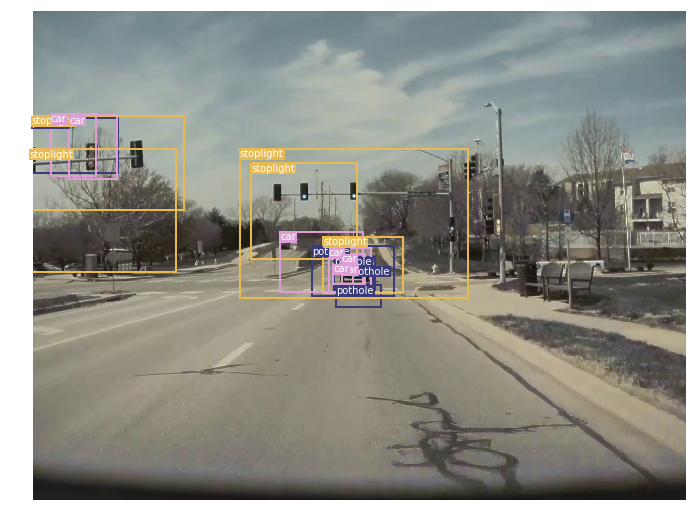

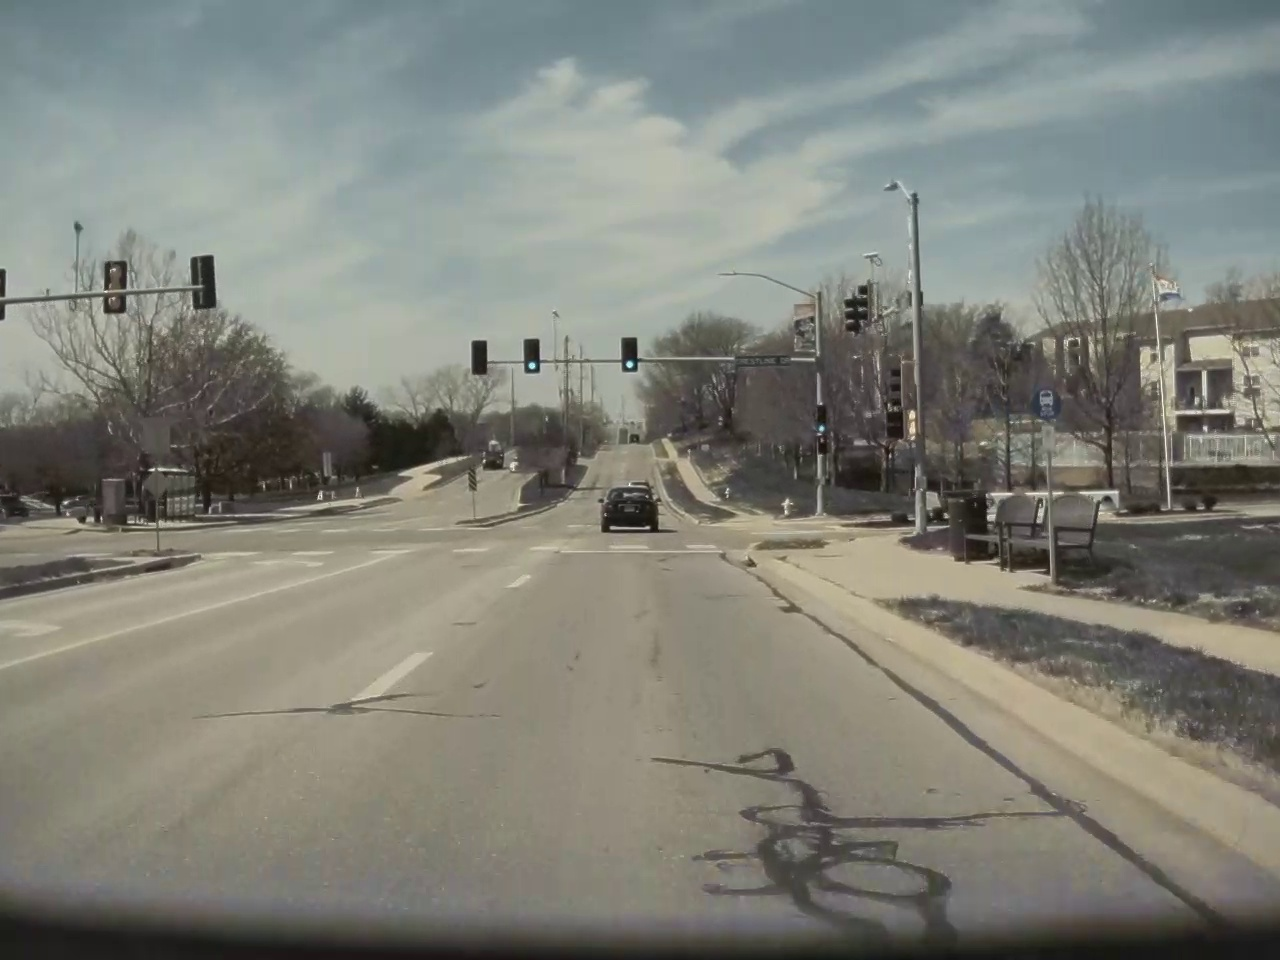

In [41]:
# Load image and get detections
img_path = "/Users/jennifercooper/Projects/Tesla/PyTorchTraining/Potholes/data/train/1/2020-04-01_12-59-14_00052.jpg"
from PIL import Image #have to reimport due to import below 
prev_time = time.time()
img = Image.open(img_path)
#img.show()
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))
# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x
if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(
             unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h,
             linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], 
                color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"),        
                  bbox_inches='tight', pad_inches=0.0)
plt.show()

# Display Original
from IPython.display import Image
Image(filename=img_path,width=300)